# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, LayerNormalization


import os
import string
from random import randint
from pickle import load
import joblib

# Preprocessing & data cleaning

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    position = text.find('Alice was beginning to get very tired of sitting by her')
    text = text[position:]
    position = text.find('THE END')
    text = text[:position]
    return text

def clean_doc(doc):
    doc = doc.replace('--', ' ')
    tokens = doc.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    return tokens

def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

in_filename = 'book.txt'
doc = load_doc(in_filename)
print(doc[:200])

tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    sequences.append(line)

print('Total Sequences: %d' % len(sequences))

out_filename = 'Sequences.txt'
save_doc(sequences, out_filename)

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
co
['alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to', 'do', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', 'what', 'is', 'the', 'use', 'of', 'a', 'thought', 'alice', 'pictures', 'or', 'so', 'she', 'was', 'considering', 'in', 'her', 'own', 'mind', 'as', 'well', 'as', 'she', 'could', 'for', 'the', 'hot', 'day', 'made', 'her', 'feel', 'very', 'sleepy', 'and', 'stupid', 'whether', 'the', 'pleasure', 'of', 'making', 'a', 'daisychain', 'would', 'be', 'worth', 'the', 'trouble', 'of', 'getting', 'up', 'and', 'picking', 'the', 'daisies', 'when', 'suddenly', 'a', '

## Visualizations of words

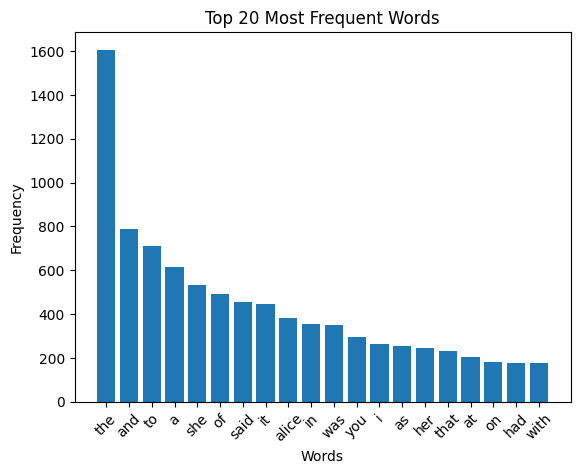

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

token_counts = Counter(tokens)
common_words = token_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

## Tokenization

In [62]:
in_filename = 'Sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
print(sequences[:200])
vocab_size = len(tokenizer.word_index) + 1

sequences = pad_sequences(sequences, padding='post')
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

[[9, 11, 298, 3, 95, 24, 448, 6, 334, 70, 15, 447, 18, 1, 2, 6, 333, 139, 3, 64, 144, 52, 722, 5, 19, 929, 56, 1, 591, 15, 447, 11, 928, 28, 8, 19, 51, 720, 52, 10, 8, 35, 39, 1, 190, 6, 4, 48, 9], [11, 298, 3, 95, 24, 448, 6, 334, 70, 15, 447, 18, 1, 2, 6, 333, 139, 3, 64, 144, 52, 722, 5, 19, 929, 56, 1, 591, 15, 447, 11, 928, 28, 8, 19, 51, 720, 52, 10, 8, 35, 39, 1, 190, 6, 4, 48, 9, 720], [298, 3, 95, 24, 448, 6, 334, 70, 15, 447, 18, 1, 2, 6, 333, 139, 3, 64, 144, 52, 722, 5, 19, 929, 56, 1, 591, 15, 447, 11, 928, 28, 8, 19, 51, 720, 52, 10, 8, 35, 39, 1, 190, 6, 4, 48, 9, 720, 52], [3, 95, 24, 448, 6, 334, 70, 15, 447, 18, 1, 2, 6, 333, 139, 3, 64, 144, 52, 722, 5, 19, 929, 56, 1, 591, 15, 447, 11, 928, 28, 8, 19, 51, 720, 52, 10, 8, 35, 39, 1, 190, 6, 4, 48, 9, 720, 52, 25], [95, 24, 448, 6, 334, 70, 15, 447, 18, 1, 2, 6, 333, 139, 3, 64, 144, 52, 722, 5, 19, 929, 56, 1, 591, 15, 447, 11, 928, 28, 8, 19, 51, 720, 52, 10, 8, 35, 39, 1, 190, 6, 4, 48, 9, 720, 52, 25, 5], [24, 448

## Custom weighted categorical crossentropy loss function

didn't end up using in model

In [ ]:
import tensorflow.keras.backend as K
# calculate class weights
token_counts = Counter(sequences[:,-1])
total_tokens = sum(token_counts.values())
class_weights = {token: total_tokens / (len(token_counts) * count) for token, count in token_counts.items()}

# normalize weights
max_weights = max(class_weights.values())
class_weights = {token: weight / max_weights for token, weight in class_weights.items()}

# assign default weight to missing tokens
default_weight = 1.0
class_weights = {i: class_weights.get(i, default_weight) for i in range(vocab_size)}

# weighted categorical cross-entropy function
def weighted_loss(class_weights):
  def loss_function(y_true, y_pred):
    weights = K.constant([class_weights[i] for i in range(len(class_weights))])
    y_true = K.cast(y_true, dtype=tf.float32)
    sample_weights = K.sum(y_true * weights, axis=-1)
    return K.mean(sample_weights * K.categorical_crossentropy(y_true, y_pred))
  return loss_function

# LSTM Model

In [53]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(128, input_shape=(X.shape[1], 1), return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
LSTMmodel.add(Dropout(0.3))
LSTMmodel.add(LSTM(64, return_sequences=False))
LSTMmodel.add(Dense(vocab_size, activation='softmax'))
LSTMmodel.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['val_accuracy'])

In [54]:
LSTMmodel.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 50, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 2418)                │         157,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 273,138 (1.04 MB)

 Trainable params: 273,138 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
LSTMmodel.fit(X, y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.0646 - loss: 6.5040 - val_accuracy: 0.0781 - val_loss: 5.4964
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 257ms/step - accuracy: 0.0750 - loss: 5.4134 - val_accuracy: 0.0781 - val_loss: 5.5017
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.0726 - loss: 5.4006 - val_accuracy: 0.0781 - val_loss: 5.4835
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - accuracy: 0.0755 - loss: 5.3703 - val_accuracy: 0.0781 - val_loss: 5.4672
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.0745 - loss: 5.3407 - val_accuracy: 0.0781 - val_loss: 5.4663
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.0718 - loss: 5.3530 - val_accuracy: 0.0781 - val_loss: 5.4543
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.0722 - loss: 5.3261 - val_accuracy: 0.0785 - val_loss: 5.4498
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.0739 - loss: 5

# Basic RNN Model

In [59]:
basicRNNmodel = Sequential()
basicRNNmodel.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
basicRNNmodel.add(SimpleRNN(128, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l1_l2(0.01,0.01)))
basicRNNmodel.add(SimpleRNN(128, activation='tanh', return_sequences=True))
basicRNNmodel.add(Dropout(0.2))
basicRNNmodel.add(SimpleRNN(64, activation='tanh', return_sequences=True))
basicRNNmodel.add(SimpleRNN(64, activation='tanh', return_sequences=False))
basicRNNmodel.add(Dense(vocab_size, activation='softmax'))
basicRNNmodel.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [66]:
basicRNNmodel.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 50, 100)             │         241,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ (None, 50, 128)             │          29,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ (None, 50, 128)             │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_18 (SimpleRNN)            │ (None, 50, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_19 (SimpleRNN)            │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 2418)                │         157,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,445,360 (5.51 MB)

 Trainable params: 481,786 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 963,574 (3.68 MB)

In [57]:
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=15, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)

In [60]:
basicRNNmodel.fit(X, y, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, lr_schedule])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.0491 - loss: 13.7657 - val_accuracy: 0.0781 - val_loss: 5.7200 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 0.0710 - loss: 5.4896 - val_accuracy: 0.0781 - val_loss: 5.5019 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.0721 - loss: 5.3980 - val_accuracy: 0.0781 - val_loss: 5.5136 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - accuracy: 0.0723 - loss: 5.4093 - val_accuracy: 0.0948 - val_loss: 5.5183 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - accuracy: 0.0717 - loss: 5.3897 - val_accuracy: 0.0781 - val_loss: 5.5207 - learning_rate: 0.0010
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.0715 - loss: 5.4208 - val_accuracy: 0.0781 - val_loss: 5.5378 - learning_rate: 0.0010
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - accuracy: 0.

# Text Generation

In [65]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        yhat = np.argmax(model.predict(encoded, verbose=0), axis=-1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

in_filename = 'Sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1


for i in range(10):
  seed_text = lines[randint(0,len(lines))]
  print(f'{i+1}. Seed Text: ' + seed_text + '\n')

  generated = generate_seq(basicRNNmodel, tokenizer, seq_length, seed_text, 50)
  print('Generated Text: ' + generated + '\n\n')



1. Seed Text: so awfully have answered three questions and that is said his father give yourself airs do you think i can listen all day to such stuff be off or kick you down is not said said the caterpillar quite right said alice timidly of the words have got is wrong from

Generated Text: and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and


2. Seed Text: silent the king laid his hand upon her arm and timidly said my dear she is only a the queen turned angrily away from him and said to the knave them the knave did so very carefully with one foot said the queen in a shrill loud voice and the three

Generated Text: and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and


3. Seed Text: flapper across